# Forecasting 


In time-series, we expect patterns to persist as we progress through time. Therefore, we first 1) find the pattern (selecting the correct model) and then 2) predict the future. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
import sklearn 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

# Loading the data

In [2]:
raw_data = yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI",
                             start="1994-01-07", end="2019-09-01",
                             interval="1d", group_by="ticker", 
                             auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()
df_comp.head()

^FTSE                                                \
                   Open         High          Low        Close Volume   
Date                                                                    
1994-01-07  3401.399902  3446.800049  3398.699951  3446.000000    0.0   
1994-01-10  3465.699951  3468.100098  3430.000000  3440.600098    0.0   
1994-01-11  3442.500000  3442.500000  3413.500000  3413.800049    0.0   
1994-01-12  3394.800049  3402.399902  3372.000000  3372.000000    0.0   
1994-01-13  3380.699951  3383.300049  3356.899902  3360.000000    0.0   

                 ^GSPC                                                   \
                  Open        High         Low       Close       Volume   
Date                                                                      
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0   
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0   
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0   
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0   
1994-01-13  474.170013  474.170013  471.799988  472.470001  277970000.0   

                 ^GDAXI                                                \
                   Open         High          Low        Close Volume   
Date                                                                    
1994-01-07  2218.959961  2227.639893  2201.820068  2224.949951    0.0   
1994-01-10  2231.840088  2238.010010  2222.000000  2225.000000    0.0   
1994-01-11  2225.429932  2235.610107  2225.179932  2228.100098    0.0   
1994-01-12  2227.120117  2227.790039  2182.060059  2182.060059    0.0   
1994-01-13  2171.500000  2183.709961  2134.100098  2142.370117    0.0   

                   ^N225                                                   
                    Open          High           Low         Close Volume  
Date                                                                       
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766    0.0  
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453    0.0  
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000    0.0  
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859    0.0  
1994-01-13  18770.380859  18823.380859  18548.750000  18577.259766    0.0

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
df_comp.drop(['^GSPC', '^GDAXI', '^FTSE', '^N225'], axis=1, inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

# Creating Returns

In [6]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

In [7]:
# normalize
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

In [8]:
df_comp.head()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000,-0.239860,-0.778935,0.139330,0.226696,100.000000,100.000000,100.000000,100.000000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859,0.008438,-1.224443,-2.066336,1.669606,-3.518009,157.194491,-1483.049430,736.495480
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766,-0.358524,-0.355872,-1.818921,-1.152615,149.471895,45.686963,-1305.474516,-508.440739
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219,0.516435,1.208336,0.405156,2.134004,-215.306731,-155.126650,290.787975,941.350333


# Splitting the Data 

In [9]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

# Fitting a Model

In [10]:
model_ar = ARIMA(df.ftse, order=(1, 0, 0))  # AR(1)
results_ar = model_ar.fit()

# Simple Forecasting

In [11]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [12]:
start_date = '2014-07-16'
end_date = '2019-01-01'

In [13]:
df_pred = results_ar.predict(start=start_date, end=end_date)

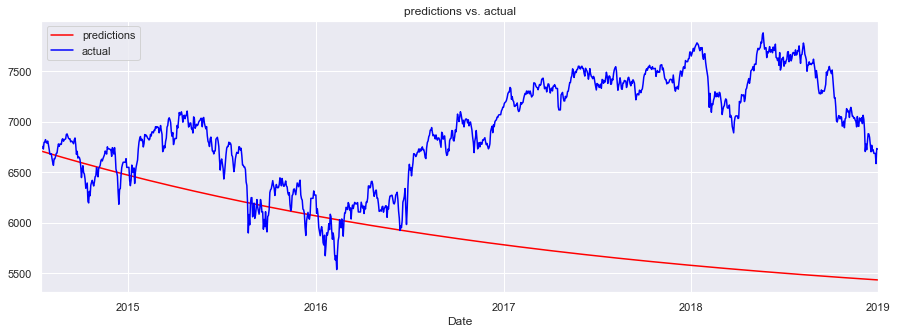

In [14]:
df_pred[start_date:end_date].plot(figsize=(15, 5), color='red')
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title("predictions vs. actual")
plt.legend(["predictions", "actual"])
plt.show()

Price is only decreasing which is unrealistic. This is because we are using a simple AR model. In AR, the predictions are only based on the constant and the prices from the previous period. Every new value is just a fraction of the previous one put on tope of the consant term. 

$$
Y_{t+1} = c + \phi_1 Y_t \\
Y_{t+2} = c + \phi_1 Y_{t+1} \\
... \\
Y_{t+n} = c + \phi_1 Y_{t+n-1} \\
$$

Also, remember we do not have residual values for the future. 


From here, we verify that the AR model is so bad at estimating non-stationary data.

# Using Returns Instead

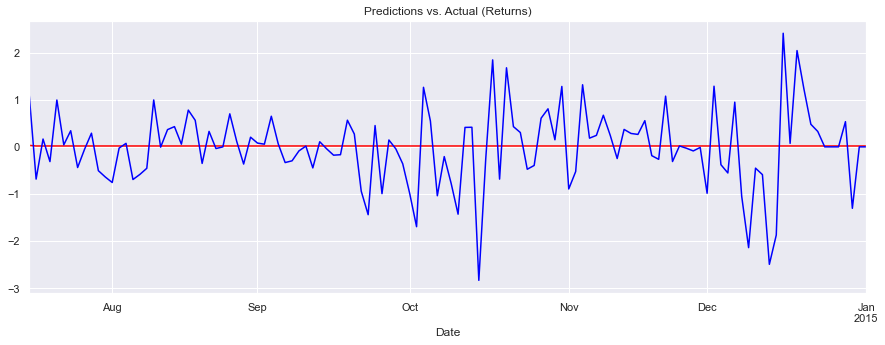

In [15]:
end_date = "2015-01-01"

model_ret_ar = ARIMA(df.ret_ftse[1:], order=(1, 0, 0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start=start_date, end=end_date)

df_pred_ar[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.show()

Constant prediction tells us that the constant and the coefficient term must be very small. If we check out the p-values, they are not even significant. This means our predictions barely move over time.

Even if we change the order to (5, 0, 0), it shows a little move at first flattens out quickly. This means even if we increase the model order, it makes little difference in the forecasting capabilities of the model.

In [16]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 0)   Log Likelihood               -8344.717
Method:                       css-mle   S.D. of innovations              1.151
Date:                Wed, 24 Feb 2021   AIC                          16695.434
Time:                        22:22:04   BIC                          16715.189
Sample:                    01-11-1994   HQIC                         16702.334
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0191      0.015      1.243      0.214      -0.011       0.049
ar.L1.ret_ftse    -0.0231      0.014     -1.692      0.091      -0.050       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.2413           +0.0000j           43.2413            0.5000
-----------------------------------------------------------------------------
"""

# MA

MA looks similar to AR. It is constant. This is because predictions are equal to the constant after the Q-th prediction, we no longer have error terms in the data. 

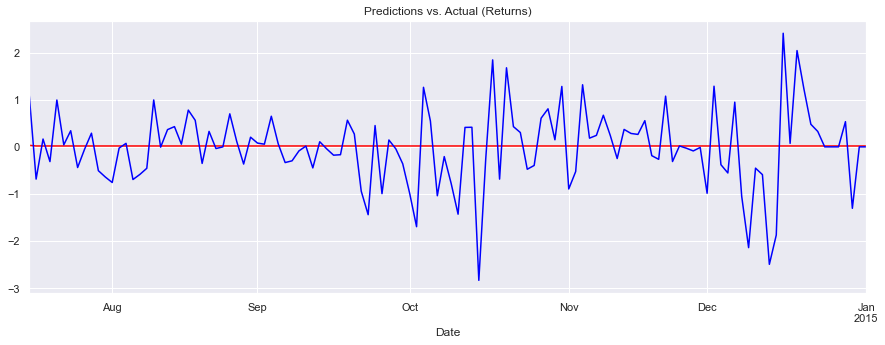

In [17]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0, 0, 1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start=start_date, end=end_date)

df_pred_ma[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.show()

In [18]:
df_pred_ma.head()

2014-07-16    0.032676
2014-07-17    0.019121
2014-07-18    0.019121
2014-07-21    0.019121
2014-07-22    0.019121
Freq: B, dtype: float64

# ARMA

We see repetition of what we have seen in AR and MA models; very constant value from afar.

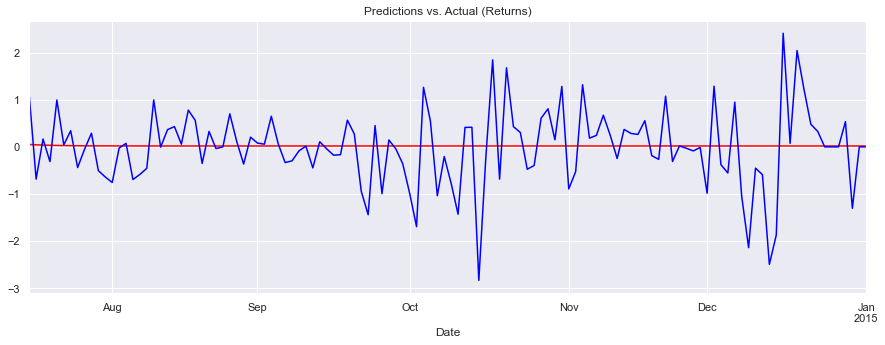

In [19]:
end_date = "2015-01-01"

model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1, 0, 1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start=start_date, end=end_date)

df_pred_arma[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.show()

In [20]:
df_pred_arma.head()

2014-07-16    0.051210
2014-07-17    0.043852
2014-07-18    0.038184
2014-07-21    0.033818
2014-07-22    0.030455
Freq: B, dtype: float64

In [21]:
df_pred_arma.tail()

2014-12-26    0.019172
2014-12-29    0.019172
2014-12-30    0.019172
2014-12-31    0.019172
2015-01-01    0.019172
Freq: B, dtype: float64

The ARMA provides more reasonable predictions as they don't just die off immediately. However, the shifts are always in the same direction (downward). We will still be having constantly decreasing returns, which isn't realistic.

# ARMAX

We will be using returns of other market indices as exogeneous variables.

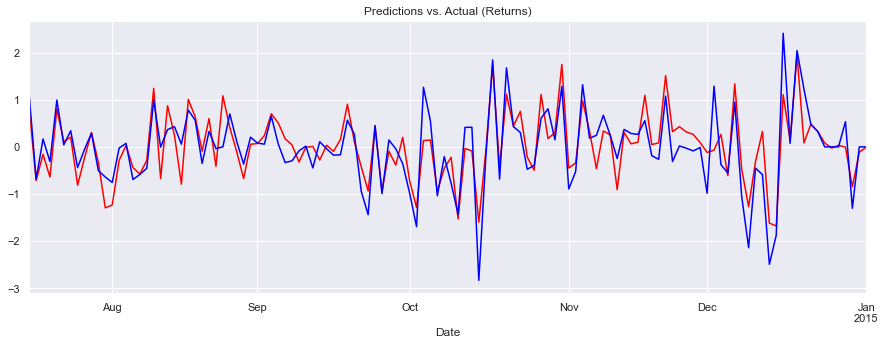

In [22]:
end_date = "2015-01-01"

model_ret_armax = ARIMA(df.ret_ftse[1:], exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order=(1, 0, 1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start=start_date, end=end_date,
                                          exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_armax[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.show()

This looks much more promising than the AR, MR, ARMA models. This indicates including outside factors improved the predictive power drastically. We're allowing the model to use the today's information as well as past.

However, it makes forecasting impossible. 
- Predictions = in-sample estimation 
- forecasts = out-of-sample estimations

We can make good predictions using test or validation as we use the known external data in the dataset, but we will make poor forecasts because we do not have future data. 

Therefore, MAX models can be great when analyzing data but poor when we try to forecast it. 

# SARMA

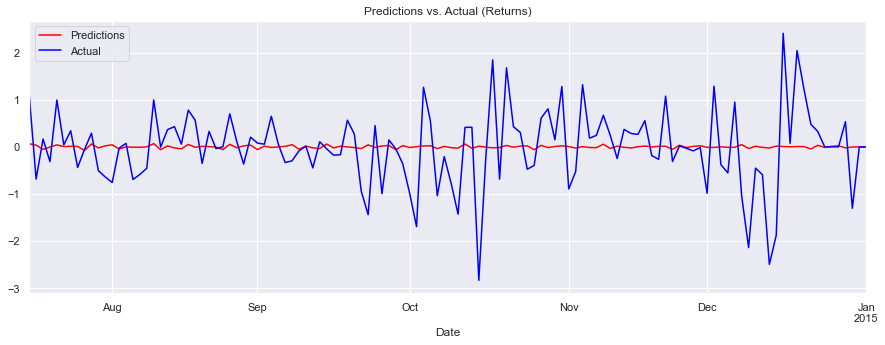

In [23]:
end_date = "2015-01-01"

model_ret_sarma = SARIMAX(df.ret_ftse[1:], order=(1, 0, 1), seasonal_order=(3, 0, 2, 5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start=start_date, end=end_date)

df_pred_sarma[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.legend(['Predictions', 'Actual'])
plt.show()

This time, the predictions are wiggly instead of constant throughout the time. However, the magnitude is small compared to actual returns. This means SARMA models anticipate greater stability than the MAX model we examined earlier. However, their accuracy is lacking. 

# SARMAX

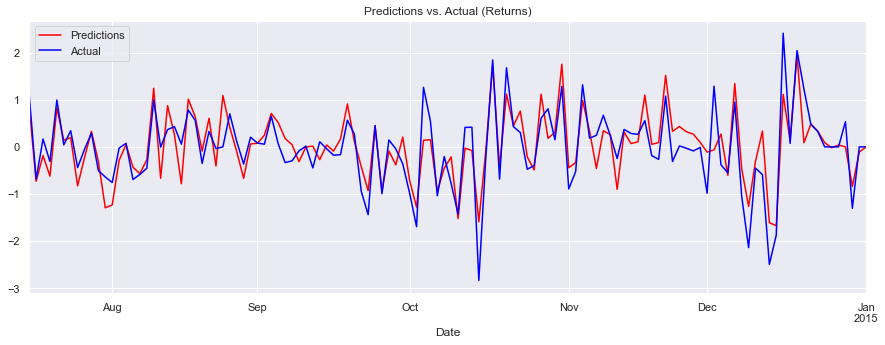

In [24]:
end_date = "2015-01-01"

model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order=(1, 0, 1), seasonal_order=(3, 0, 2, 5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start=start_date, end=end_date,  exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_sarimax[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.legend(['Predictions', 'Actual'])
plt.show()

Adding exogenous variables significantly improved the predictions.

# ARIMA

In [26]:
model_auto = auto_arima(df.ret_ftse[1:])

In [29]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date])),
                           index=df_test[start_date:end_date].index)

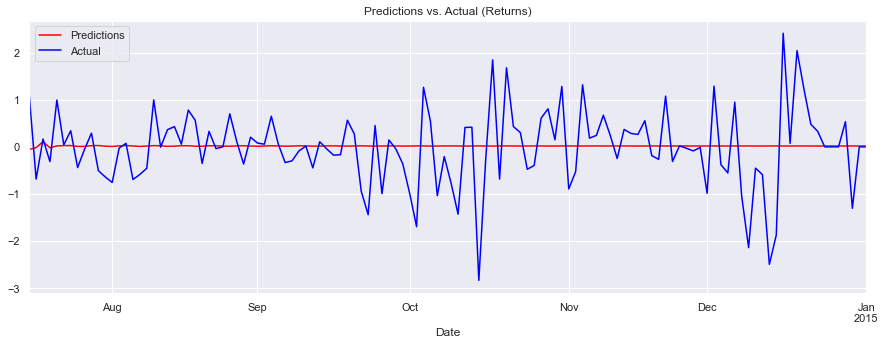

In [31]:
df_auto_pred[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.legend(['Predictions', 'Actual'])
plt.show()

The prediction doesn't match with the actual. This is default model so we can improve.

# SARIMAX

In [33]:
model_sarimax_auto = auto_arima(df.ret_ftse[1:], 
                                exogenous=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                                m=5, max_p=5, max_q=5, max_P=5, max_Q=5)

df_sarimax_auto_pred = pd.DataFrame(model_sarimax_auto.predict(n_periods=len(df_test[start_date:end_date]), 
                            exogenous=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                           index=df_test[start_date:end_date].index)

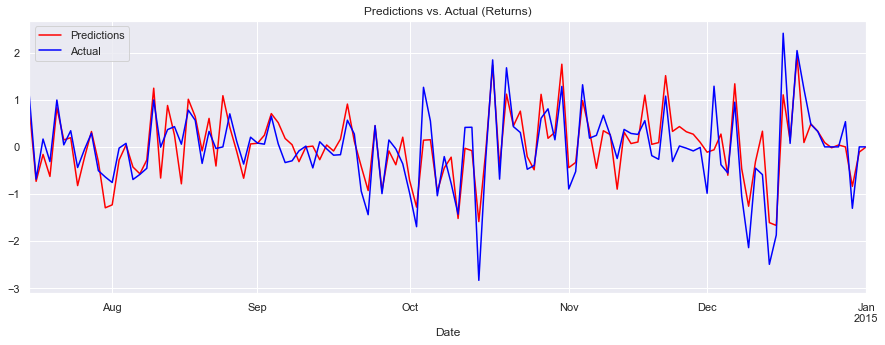

In [34]:
df_sarimax_auto_pred[start_date: end_date].plot(figsize=(15, 5), color='red')
df_test.ret_ftse[start_date: end_date].plot(color='blue')
plt.title('Predictions vs. Actual (Returns)')
plt.legend(['Predictions', 'Actual'])
plt.show()

# Pitfalls/Peculiarities

* General pitfalls 
  * Model-specific and data-dependent 
  * The models we examine in this section were non-integrated 
  * Picking an incorrect ype of model (integrated vs. non-integrated) depending on the data 
  * We can always forecast stationary returns and then create the prices based on these returns 
* Integrated Models (e.g. ARIMA)
  * lack of visualization. we can't plot the integrated pridictions against the actual prices. To do that, create a time series of 'delta' from the testing set in order to compare the integrated predictions with actual values 
* AR 
  * It only depends on the past values and the constant coefficient. 
  * The more past lags we include, the more time it takes to flatten out. 
  * The monotonous nature of the predictions makes it unreasonable. 
* MA
  * We can't make long run predictions if we're relying on error terms 
  * We can't autogenerate future residuals since we don't have actual values anymore 
  *  One way to get around it is to manually create white noise residual values for the entire time period we're forecasting. Then we can recursively create a time series of predictions based on the regression coefficients and the last few known residuals. 
* ARMA
  * Prone to experience both types of erros for AR and MA
* MAX (ARMAX, SARIMAX)
  * If the exogenous variable are other time series as well, we'll run into some trouble 